In [1]:
# Import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in csv for all universities
df = pd.read_csv('all_posts.csv')
df.shape

(2996, 7)

Social media tends to have a lot of memes/non-sensical discussion. For this project it would be valuable to filter out these types of posts and focus on posts that are more likely to have criticisms about the university.

In [3]:
# Want to see post flairs, and subsequently filter for non-shitposts
df['flair'].unique()

array(['Transfers', 'Discussion', 'Humour', 'Serious', 'News', 'Other',
       'Rant', 'Health', 'Clubs/Sports', 'Social', 'Event', 'Courses',
       'Waterloo #173', 'Academics', 'Advice', 'Confirmed', 'Meta', nan,
       'Shitpost', 'Lost & Found', 'Question', 'Politics', 'Life Advice',
       'Admissions', 'Finances', 'Programs', 'ACORN/Quercus/Outlook',
       'Free Speech', 'Waterloo #201–250', 'UTM/UTSC',
       "I'm in High School", 'Jobs', 'Photography & Art',
       'Pho(ur seasons)tography & Art', '@ SFU (Exception)', 'Megathread',
       'Congrats, you made it!', 'Photography &amp; Art',
       'Humour - Satire', 'SFU = Studying For UBC', 'Prose', '🍁',
       '100% super duper confirmed by the r/byssey', '🔥🔥🔥',
       'Ghost-type Humour', 'Unverified', 'Lost Dog', '🎉🎉🎉',
       'Read Comments Section for full context', 'Missing Person', 'F',
       'Spicy', 'HQ Post', 'Spicy Meme', 'We did it, reddit!',
       'HQ shitpost', 'Certified Dank', 'shitpost', 'Political',
       

In [4]:
# Most popular flairs
df['flair'].value_counts()[:10]

flair
Humour               961
Discussion           223
Other                159
Photography & Art    116
shitpost              73
News                  49
Academics             28
Advice                22
Courses               22
HQ Post               21
Name: count, dtype: int64

In [5]:
df = df[df['flair'].isin(['Humour', 'Discussion', 'Other', 'News', 'Academics', 'Advice', 'Courses', 'HQ Post'])]
df.shape

(1485, 7)

# Cleaning Data

In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Init stopwords
stop_words = set(stopwords.words("english"))

def clean_text(df):
    '''
    This function does 3 things

    1. Combines text from title, description and comments
    2. Normalizes university names
    3. Tokenizes and lemmatizes text and removes stopwords + reddit specific words

    '''
    remove_words = ['removed', 'deleted', '[ removed by reddit ]', '[deleted]']
    # custom_stopwords = {'student', 'course', 'people', 'get', 'like', 'time', 'year', 'would'}
    # Combine text from title, description and comments
    def combine_text(text): 

        if isinstance(text, list):
            return ' '.join([word for word in text if isinstance(word, str) and word.lower() not in remove_words])
        elif isinstance(text, str): 
            # Filter out posts removed by reddit
            if re.search(r"\[?\s*removed by reddit.*?\]?", text, flags=re.IGNORECASE):
                return ''
            return text
        return ''

    
    
    # Normalize university names
    def normalize_university(text):
        # Regex to normalize uni names
        text = re.sub(r'u\sof\st', 'uoft', text)
        text = re.sub(r'university of toronto', 'uoft', text)
        text = re.sub(r'university of british columbia', 'ubc', text)
        return text

    # Tokenize + lematize + remove stopwords
    def tokenize_and_lemmatize(text): 

        # Tokenize
        tokens = word_tokenize(text)

        # Filter for strings
        words = [word for word in tokens if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]
    
    # Combine text
    df['combined_text'] = (df['title'].apply(combine_text).fillna('') + ' ' +
                       df['description'].apply(combine_text).fillna('') + ' ' +
                       df['comments'].apply(combine_text))

    # Lower + removing trailing charsa
    df['combined_text'] = df['combined_text'].str.lower().str.strip()
    
    # Normalize university names
    df['combined_text'] = df['combined_text'].apply(normalize_university)

    # Tokenize + lemmatize
    df['lemmatized_tokens'] = df['combined_text'].apply(tokenize_and_lemmatize)

    # Return cleaned df
    return df

df = clean_text(df)

df.head()

,date_created,title,description,comments,upvotes,flair,university,combined_text,lemmatized_tokens
1,2024-11-08 03:24:09,[ Removed by Reddit ],[ Removed by Reddit on account of violating th...,"['Ik this man, he’s getting cooked. Maybe uoft...",2939,Discussion,UofT,"['ik this man, he’s getting cooked. maybe uoft...","[man, getting, cooked, maybe, uoft, anything, ..."
2,2020-11-13 19:48:06,I want a ps5,NaN,"['i LOVE how low effort this looks', 'pain', ...",2749,Humour,UofT,i want a ps5 ['i love how low effort this lo...,"[want, love, low, effort, look, u, made, day, ..."
4,2025-05-14 00:11:02,University of Toronto Faculty Association vote...,NaN,"['Big W, honestly im surprised', 'W faculty', ...",2163,News,UofT,uoft faculty association votes to divest from ...,"[uoft, faculty, association, vote, divest, isr..."
5,2025-04-12 20:03:29,uoft academic offence cases are literally so e...,NaN,"['""The Panel does not accept this explanation ...",1996,Other,UofT,uoft academic offence cases are literally so e...,"[uoft, academic, offence, case, literally, ent..."
7,2024-05-29 21:56:51,Lady drives into cement in front of St George ...,NaN,['Thank you for posting concrete evidence of h...,1905,Humour,UofT,lady drives into cement in front of st george ...,"[lady, drive, cement, front, st, george, stati..."


## Investigating top k words

In [7]:
from collections import Counter

def get_topk_words(df, k):
    '''
    Takes a df and returns top k words from tokens
    '''
    all_tokens = [token for row in df['lemmatized_tokens'] for token in row]

    # Count frequencies
    token_counts = Counter(all_tokens)

    # Get top K words
    top_k = token_counts.most_common(k)

    return top_k

# Get top 10 most common words across all posts
print(f'---All Posts---\n{get_topk_words(df, 10)}')

# Get top 10 most common words across flairs
for flair in df['flair'].unique():
    print(f'---{flair}---\n{get_topk_words(df[df['flair'] == flair], 10)}')


---All Posts---
[('people', 7483), ('like', 7290), ('student', 6169), ('get', 5848), ('year', 5517), ('one', 4958), ('time', 4590), ('would', 4538), ('think', 4144), ('course', 3882)]
---Discussion---
[('people', 3817), ('like', 3058), ('student', 2560), ('get', 2262), ('would', 1921), ('one', 1875), ('year', 1851), ('think', 1815), ('time', 1560), ('know', 1559)]
---Humour---
[('like', 2250), ('get', 1882), ('year', 1841), ('people', 1606), ('one', 1567), ('student', 1558), ('course', 1456), ('time', 1429), ('would', 1160), ('class', 1133)]
---News---
[('people', 699), ('student', 545), ('like', 378), ('get', 358), ('would', 343), ('one', 328), ('think', 313), ('uoft', 269), ('know', 269), ('http', 267)]
---Other---
[('like', 749), ('people', 556), ('year', 533), ('one', 527), ('get', 517), ('student', 495), ('would', 456), ('think', 436), ('time', 433), ('uoft', 362)]
---Courses---
[('course', 336), ('student', 262), ('like', 218), ('class', 211), ('time', 149), ('one', 145), ('year'

It seems all posts feature words that are probably common throughout the entire subreddit. Need to figure out a way to explore specific topics people are talking about..

Mutual Information (MI). If we treat our flair as a rough topic label, we can use MI to tell us information that is shared in the non-linear relationships between tokens and flairs.

In [ ]:
# 500 most common words
top_500 = get_topk_words(df, 500)

# Create matrix where columns have bool indicating whether specific post has a word 
mi_df = pd.DataFrame(df['flair'])

for word, _ in top_500:
    mi_df[word] = df['lemmatized_tokens'].apply(lambda tokens: int(word in tokens))

In [9]:
from sklearn.metrics import mutual_info_score

def getMI(topk, df, label_column = 'flair'):

    # Get flair names
    unique_labels = df[label_column].unique()

    # Placeholder df
    overalldf = pd.DataFrame()

    for flair in unique_labels:
        miscore = []
        label = df[label_column].copy()


        label[label != flair] = 0
        label[label == flair] = 1

        # Get MI for topk words in flair
        for word in topk:
            miscore.append([word[0]] + [mutual_info_score(label, df[word[0]])] + [flair])

        # Combine scores of all words for flair into df
        miscoredf = pd.DataFrame(miscore).sort_values(1, ascending = False)
        miscoredf.columns = ['word', 'mi', 'flair']
        overalldf = pd.concat([overalldf, miscoredf])

    return overalldf

In [10]:
# Add university back into df 
mi_df['university'] = df['university']

uoft_mi_scores = getMI(top_500, mi_df[mi_df['university'] == 'UofT'])
ubc_mi_scores = getMI(top_500, mi_df[mi_df['university'] == 'UBC'])
mcgill_mi_scores = getMI(top_500, mi_df[mi_df['university'] == 'McGill'])

# Display UofT top mi words by flair
uoft_mi_scores.set_index(['word']).groupby('flair')['mi'].nlargest(10).reset_index()

,flair,word,mi
0,Academics,final,0.009494
1,Academics,test,0.007639
2,Academics,try,0.007560
3,Academics,cheat,0.006734
4,Academics,cheating,0.006734
...,...,...,...
65,Other,science,0.005963
66,Other,average,0.005336
67,Other,thanks,0.005097
68,Other,education,0.004984


In [11]:
# UBC
ubc_mi_scores.set_index(['word']).groupby('flair')['mi'].nlargest(10).reset_index()

,flair,word,mi
0,Discussion,hope,0.089152
1,Discussion,care,0.082731
2,Discussion,world,0.079777
3,Discussion,going,0.075632
4,Discussion,post,0.074031
5,Discussion,want,0.073769
6,Discussion,anyone,0.073078
7,Discussion,help,0.072177
8,Discussion,around,0.072157
9,Discussion,something,0.071614


In [12]:
# McGill
mcgill_mi_scores.set_index(['word']).groupby('flair')['mi'].nlargest(10).reset_index()

,flair,word,mi
0,HQ Post,people,0.0
1,HQ Post,studying,0.0
2,HQ Post,black,0.0
3,HQ Post,library,0.0
4,HQ Post,check,0.0
5,HQ Post,future,0.0
6,HQ Post,saw,0.0
7,HQ Post,uni,0.0
8,HQ Post,tuition,0.0
9,HQ Post,quite,0.0


# Sentiment Analysis

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer

def evalsentences(sentences, to_df = False, columns = []):
    sid = SentimentIntensityAnalyzer()
    pdlist = []

    if to_df:
        for idx, sentence in sentences.items():
            ss = sid.polarity_scores(sentence)
            pdlist.append([idx, sentence] + [ss['compound']])
        df = pd.DataFrame(pdlist, columns = ['index'] + columns)
        df.set_index('index', inplace = True)
        df.index.name = None
        return df
    
    else:
        for sentrence in sentences:
            print('\n' + sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k], end = ''))
            print()

Text(0.5, 1.0, 'Distribution of VADER sentiment scores across posts')

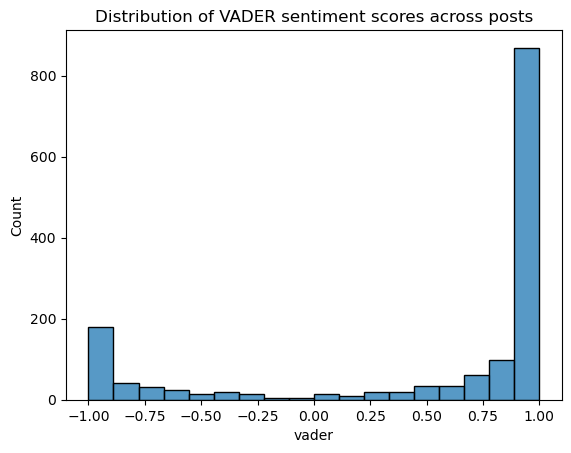

In [14]:
comments = df['combined_text']
vader_df = evalsentences(comments, to_df = True, columns = ['comments', 'vader'])

# See distribution of sentiment across posts
sns.histplot(vader_df['vader'])
plt.title('Distribution of VADER sentiment scores across posts')

In [17]:
# Set option to show longer comments
pd.set_option('display.max_colwidth', 100)

# Add flair back in
vader_df['flair'] = df['flair']

# See what percent of comments are rated negative from VADER by flair
vader_df['is_neg'] = vader_df['vader'] < 0

percent_neg = (vader_df.groupby('flair')['is_neg']
               .mean()
               .round(2) 
               ).sort_values(ascending = False)

percent_neg

flair
News          0.45
Humour        0.23
Discussion    0.22
Academics     0.18
Other         0.18
Advice        0.14
HQ Post       0.14
Courses       0.05
Name: is_neg, dtype: float64

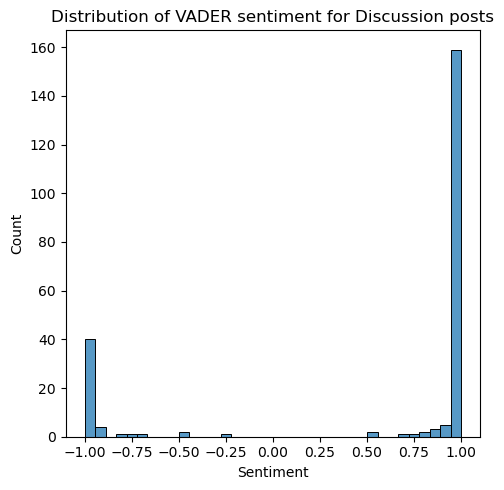

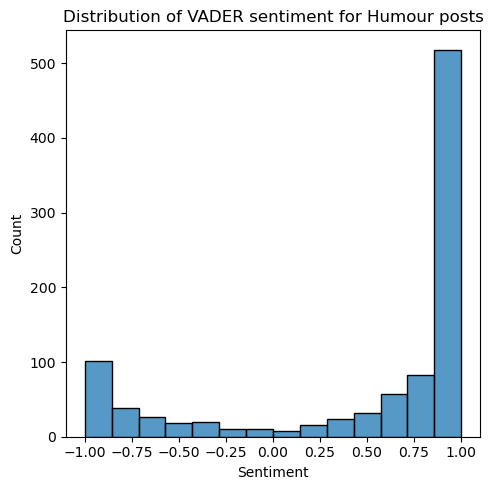

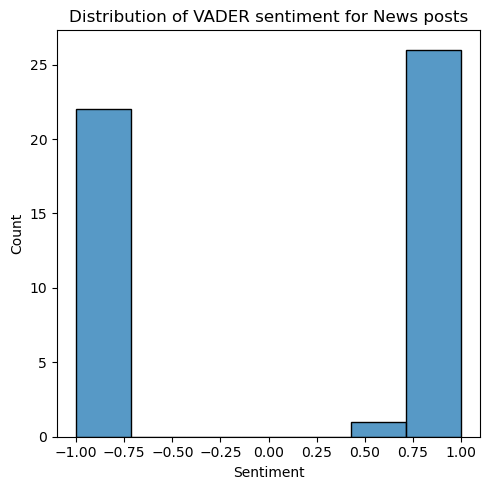

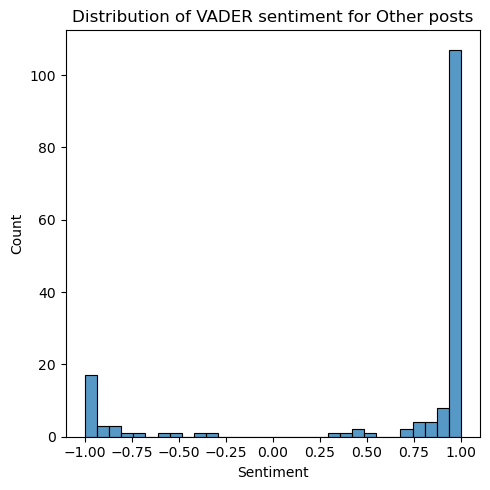

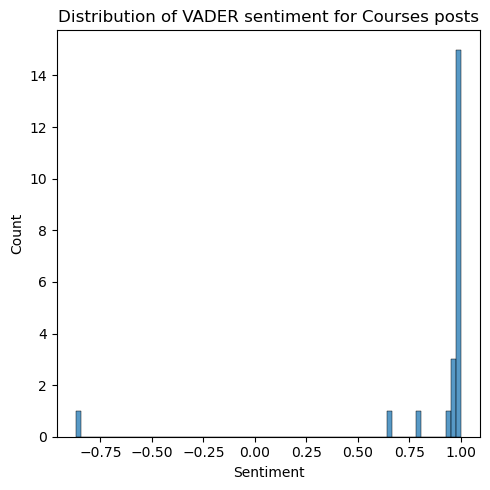

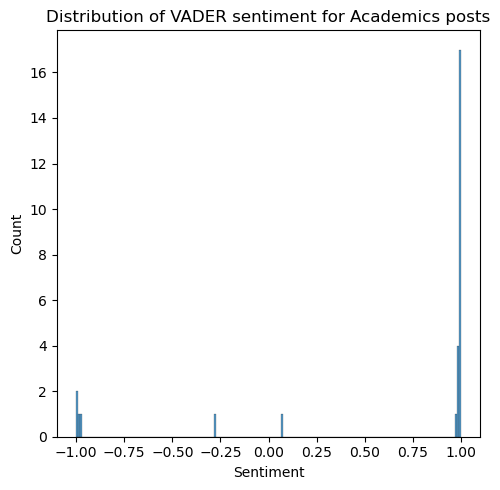

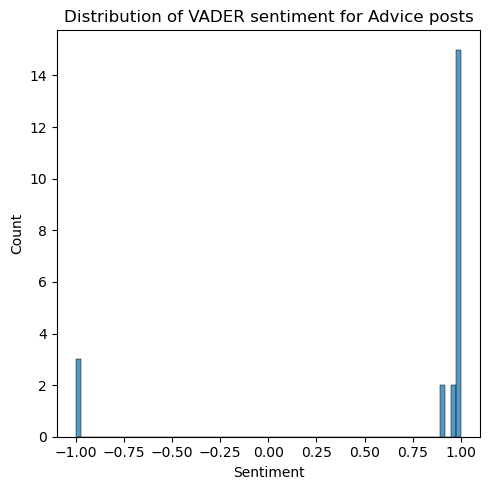

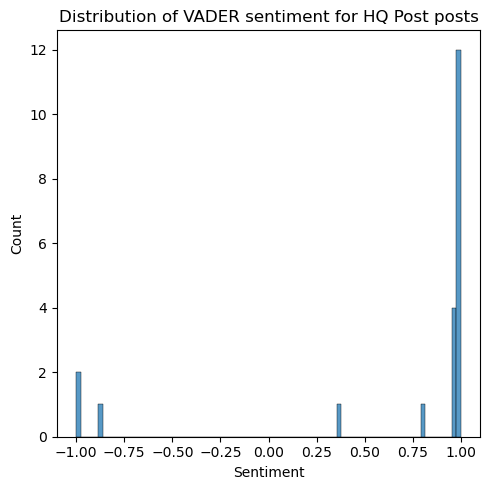

In [18]:
for flair in vader_df['flair'].unique():
    plt.figure(figsize=(5,5))
    sns.histplot(vader_df[vader_df['flair'] == flair]['vader'])
    plt.title(f'Distribution of VADER sentiment for {flair} posts')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

News posts have the highest ratio of negative sentiment whilst courses have the lowest